# VQ Layer Function Projection Evaluation

The VQ layer projects input vectors to the closest vector found in the embedding space. Closest is measured in terms of L2 (will be parameterizable in the future, e.g. cosine and L1 as well).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import tensorflow as tf

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


We generate three clusters of points and define an embedding space which contains four vectors. Three of these four vectors are somewhat aligned with the created clusters.

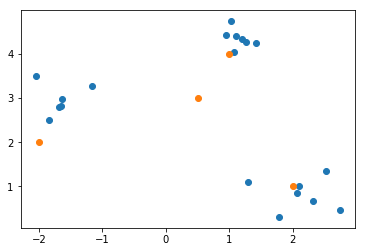

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=20, centers=3,
                  random_state=0, cluster_std=0.30)
plt.scatter(X[:, 0], X[:, 1]);

emb_space_val = np.array([[-2, 2], [.5, 3], [1, 4], [2, 1]], dtype=np.float32)
plt.scatter(emb_space_val[:, 0], emb_space_val[:, 1])

In [3]:
def vector_quantization(x: tf.Tensor, n, lookup_ord='euclidean', embedding_initializer=tf.random_normal_initializer) -> tf.Tensor:
    """Simplified version of the function in vq-layer-function, without loss and gradient skipping."""
    # shape of x is [batch, , q], where this function quantizes along dimension q
    vec_size = x.shape[2]
    with tf.variable_scope('vq'):
        # embedding space
        emb_space = tf.get_variable('emb_space', shape=[n, vec_size], dtype=x.dtype, initializer=embedding_initializer, trainable=True)
        
        # map x to y, where y is the vector from emb_space that is closest to x
        diff = tf.expand_dims(x, axis=2) - emb_space  # distance of x from all vectors in the embedding space
        dist = tf.norm(diff, lookup_ord, axis=3)  # distance between x and all vectors in emb
        emb_index = tf.argmin(dist, axis=2)
        y = tf.gather(emb_space, emb_index, axis=0)
        
        # update access counter
        one_hot_access = tf.one_hot(emb_index, depth=n)
        access_count = tf.reduce_sum(one_hot_access, axis=[0, 1], name='access_count')
        
        return y, access_count

In [4]:
tf.reset_default_graph()
point_batch = tf.placeholder(tf.float32, shape=[None, 2])
vq_in = tf.expand_dims(point_batch, axis=1)
vq_out, access_count = vector_quantization(vq_in, 4, lookup_ord=2, embedding_initializer=tf.constant_initializer(emb_space_val))
point_batch_out = tf.squeeze(vq_out)

The points of the clusters are being mapped to the closest vector in the embedding space. All embedding vectors but the one in the center are being used.

The access count reflects how many input vectors were mapped onto an embedding vector.

[6. 0. 7. 7.]


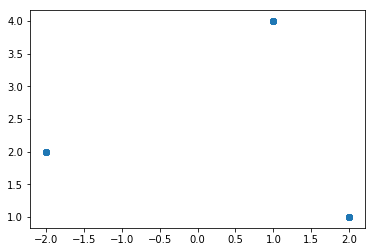

In [5]:
sess = tf.Session()
with sess.as_default():
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init)
    point_batch_out_val, access_count_val = sess.run([point_batch_out, access_count], feed_dict={point_batch:X})
    plt.scatter(point_batch_out_val[:, 0], point_batch_out_val[:, 1])
    print(access_count_val)